In [1]:
import arviz as az
import pandas as pd
import seaborn as sns
import os.path as op
import numpy as np

from bauer.utils.math import softplus_np
import matplotlib.pyplot as plt
from bauer.utils.math import softplus_np

from tms_risk.cogmodels.fit_model import build_model, get_data
from tms_risk.cogmodels.utils import plot_ppc

stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']


bids_folder  = '/data/ds-tmsrisk'

In [7]:
def get_info(model_label, bids_folder='/data/ds-tmsrisk'):
    df = get_data(bids_folder, model_label)
    model = build_model(model_label, df)
    model.build_estimation_model()
    idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'model-{model_label}_trace.netcdf'))


    return df, model, idata

def get_pars(idata, group=True):
    traces = {}

    pars_vertex = []
    pars_ips = []

    keys = ['perceptual_noise_sd', 'memory_noise_sd', 'n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_mu', 'risky_prior_std', 'safe_prior_mu', 'safe_prior_std', 'prior_mu', 'prior_std']

    for key in keys:

        if group:
            key_ = key+'_mu'
        else:
            key_ = key
        
        if key_ in idata.posterior.keys():
            print(key_)

            traces[key] = idata.posterior[f'{key_}'].to_dataframe()

            ips_values = traces[key].xs('Intercept', 0, f'{key}_regressors')


            if 'stimulation_condition[T.vertex]' in traces[key].index.get_level_values(f'{key}_regressors'):
                vertex_values = ips_values + traces[key].xs('stimulation_condition[T.vertex]', 0, f'{key}_regressors')
            else:
                vertex_values = ips_values

            if (key in ['n1_evidence_sd', 'n2_evidence_sd']) and 'evidence_sd' in idata.posterior.keys():
                if group:
                    key__ = 'evidence_sd_mu'
                else:
                    key__ = 'evidence_sd'
                
                print('yo')
                ips_values += idata.posterior[key__].to_dataframe().xs('stimulation_condition[ips]', 0, f'evidence_sd_regressors').values
                vertex_values += idata.posterior[key__].to_dataframe().xs('stimulation_condition[vertex]', 0, f'evidence_sd_regressors').values


            if key in ['perceptual_noise_sd', 'memory_noise_sd', 'n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_std', 'safe_prior_std']:
                ips_values = softplus_np(ips_values)
                vertex_values = softplus_np(vertex_values)

            pars_ips.append(ips_values)
            pars_vertex.append(vertex_values)


    pars_ips = pd.concat(pars_ips, axis=1)
    pars_vertex = pd.concat(pars_vertex, axis=1)

    pars = pd.concat((pars_ips, pars_vertex), keys=['IPS', 'Vertex'], names=['stimulation condition'])
    pars.columns.name = 'parameter'
    pars = pars.stack().to_frame('value')

    return pars


def plot_pars(pars, df, ):
    g = sns.FacetGrid(pars.reset_index(), col='parameter', sharey=False, col_wrap=3)

    g.map(sns.violinplot, 'stimulation condition', 'value', fill=True, palette=stimulation_palette, order=stimulation_order)
    g.set_titles('{col_name}')


    if len(g.axes.flat) == 6:
        g.axes.flat[2].axhline(np.log(df['n_risky'].mean()), color='k', linestyle='--')
        g.axes.flat[3].axhline(np.log(df['n_risky'].std()), color='k', linestyle='--')
        g.axes.flat[4].axhline(np.log(df['n_safe'].mean()), color='k', linestyle='--')
        g.axes.flat[5].axhline(np.log(df['n_safe'].std()), color='k', linestyle='--')

    return g


def plot_pars_diff(pars):
    tmp = pars.unstack('stimulation condition')['value']
    tmp = tmp['IPS'] - tmp['Vertex']
    g = sns.FacetGrid(tmp.to_frame('diff').reset_index(), col='parameter', col_wrap=3, sharex=False, sharey=False)

    g.map(sns.kdeplot, 'diff', fill=True, color='k')

    g.map(lambda *args, **kwargs: plt.axvline(0.0, c='k', ls='--'))

    g.set_titles('{col_name}')

    for ax, par in zip(g.axes.flat, g.col_names):
        p = (tmp.xs(par, 0, 'parameter') < 0.0).mean()
        
        if p != 0.0:
            ax.text(0.7, 0.8, f'p={p:0.3f}',
            horizontalalignment='left',
            fontsize=10,
            verticalalignment='center',
            transform = ax.transAxes)

    return g


def get_ppc(model, idata, df):
    model.build_estimation_model()
    ppc = model.ppc(trace=idata.sel(draw=slice(None, None, 10)), data=df)

    ix_risky_first = ppc.index.get_level_values('risky_first')
    ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]

    return ppc

def plot_identity_line(*args, **kwargs):

    ax = plt.gca()
    xlim, ylim = ax.get_xlim(), ax.get_ylim()

    x0 = (xlim[0] + ylim[0]) / 2.
    x1 = (xlim[1] + ylim[1]) / 2.

    plt.plot([x0, x1], [x0, x1], c='k', ls='--')

def plot_scatter_with_errors(data, xlabel='Vertex', ylabel='IPS', **kwargs):

    x = data[('mean', xlabel)]
    y = data[('mean', ylabel)] 

    xerr_min = x - data['ci_min', xlabel]
    xerr_max = data['ci_max', xlabel] - x

    yerr_min = y - data['ci_min', ylabel]
    yerr_max = data['ci_max', ylabel] - y


    plt.errorbar(x, y, [yerr_min, yerr_max], [xerr_min, xerr_max], fmt='.', markersize=0, alpha=0.5, **kwargs)
    plt.scatter(data[('mean', xlabel)], data[('mean', ylabel)], marker='.', s=50, **kwargs)


def plot_individual_condition_difference(subject_pars):
    mean_pars = subject_pars.groupby(['stimulation condition', 'subject', 'parameter'])['value'].mean().to_frame('mean')
    ci_pars = subject_pars.groupby(['stimulation condition', 'subject', 'parameter'])['value'].apply(lambda x: pd.Series(az.hdi(x.values.ravel(), .95), index=pd.Index(['ci_min', 'ci_max']))).to_frame('value').unstack(-1)['value']

    par_stats = mean_pars.join(ci_pars)


    g = sns.FacetGrid(par_stats.unstack(['stimulation condition']).reset_index(), col='parameter', col_wrap=3, sharex=False, sharey=False)

    g.map_dataframe(plot_scatter_with_errors, color='k')
    g.map(plot_identity_line)
    g.set_titles('{col_name}')
    # g.set(xlabel='Vertex', ylabel='IPS')
    g.set_xlabels('Vertex')
    g.set_ylabels('IPS')

    return g

In [8]:
def process_model(model_label):
    df, model, idata = get_info(model_label)
    pars = get_pars(idata)

    g = plot_pars(pars, df)
    g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars.pdf'))

    g = plot_pars_diff(pars)
    g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars_diff.pdf'))

    subject_pars = get_pars(idata, group=False)

    plot_individual_condition_difference(subject_pars)

    plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars_before_after.pdf'))

    ppc = get_ppc(model, idata, df)

    for plot_type in [5,6,7]:
        plot_ppc(df, ppc, plot_type=plot_type, level='group')
        plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_ppc{plot_type}.pdf'))
    

# Model 1

In [4]:
model_label = '1'
df, model, idata = get_info(model_label)
pars = get_pars(idata)

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:279: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', 

Dropping the baseline condition
n1_evidence_sd_mu
n2_evidence_sd_mu
risky_prior_mu_mu
safe_prior_mu_mu


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette

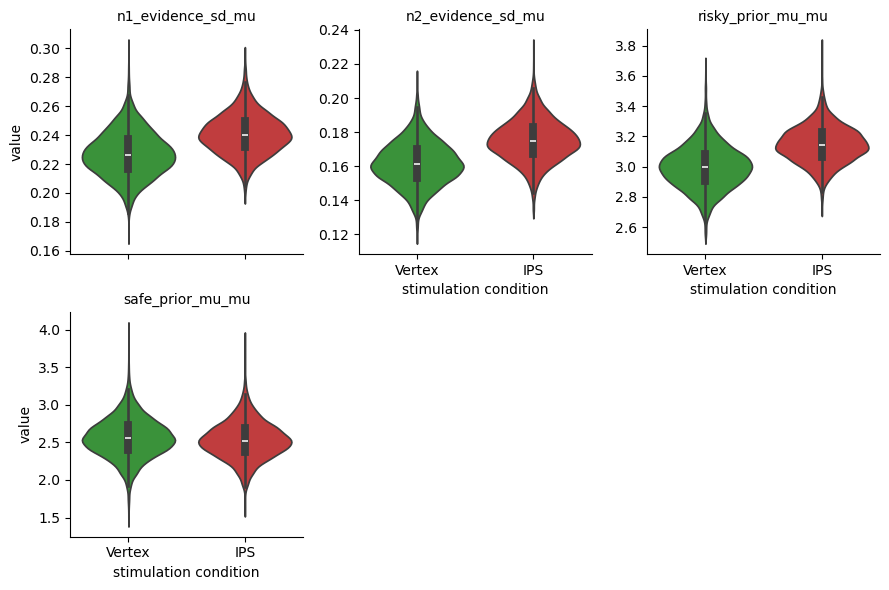

In [9]:
g = plot_pars(pars, df)
# g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars.pdf'))

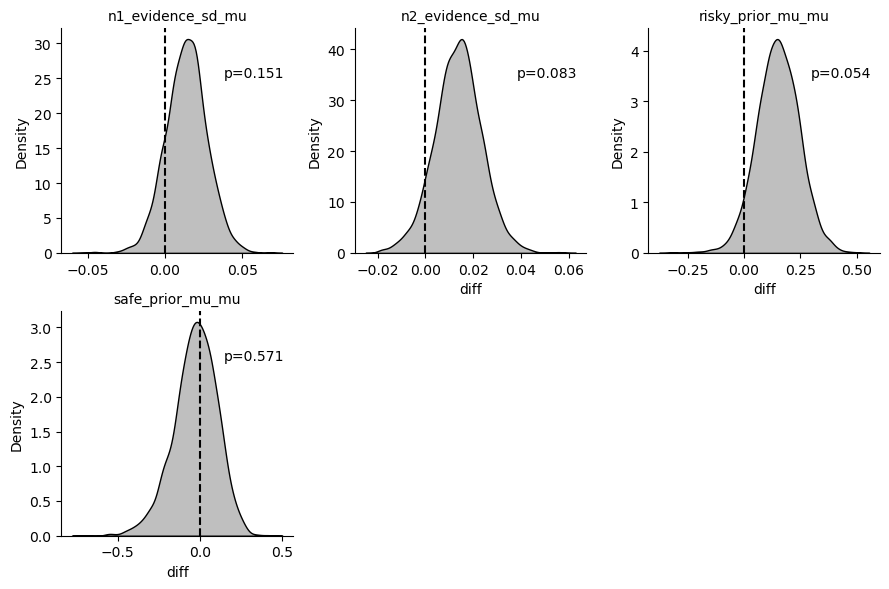

In [10]:
plot_pars_diff(pars)
# g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars_diff.pdf'))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_3304/3789290814.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ips_sd)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_3304/3789290814.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vertex_sd)


<Axes: ylabel='Density'>

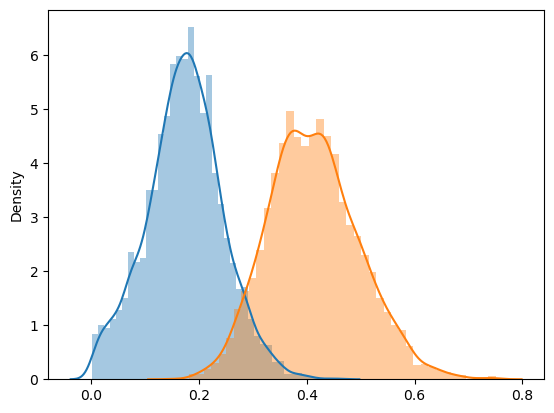

In [11]:
ips_sd = idata.posterior['n1_evidence_sd_sd'].to_dataframe().xs('Intercept', 0, -1)
vertex_sd = idata.posterior['n1_evidence_sd_sd'].to_dataframe().xs('Intercept', 0, -1) + idata.posterior['n1_evidence_sd_sd'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1)

sns.distplot(ips_sd)
sns.distplot(vertex_sd)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_84534/546978285.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ips_sd)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_84534/546978285.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vertex_sd)


<Axes: ylabel='Density'>

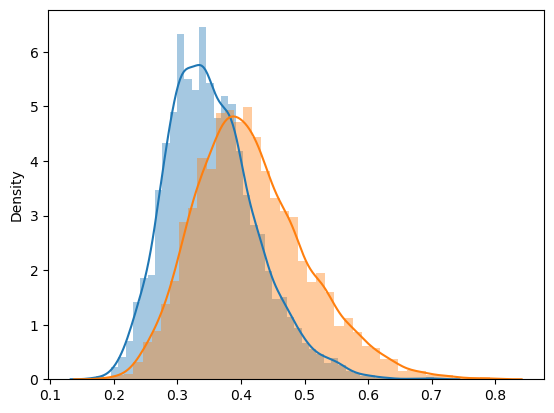

In [40]:
ips_sd = idata.posterior['n2_evidence_sd_sd'].to_dataframe().xs('Intercept', 0, -1)
vertex_sd = idata.posterior['n2_evidence_sd_sd'].to_dataframe().xs('Intercept', 0, -1) + idata.posterior['n2_evidence_sd_sd'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1)

sns.distplot(ips_sd)
sns.distplot(vertex_sd)

In [12]:
subject_pars = get_pars(idata, group=False)

n1_evidence_sd
n2_evidence_sd
risky_prior_mu
safe_prior_mu


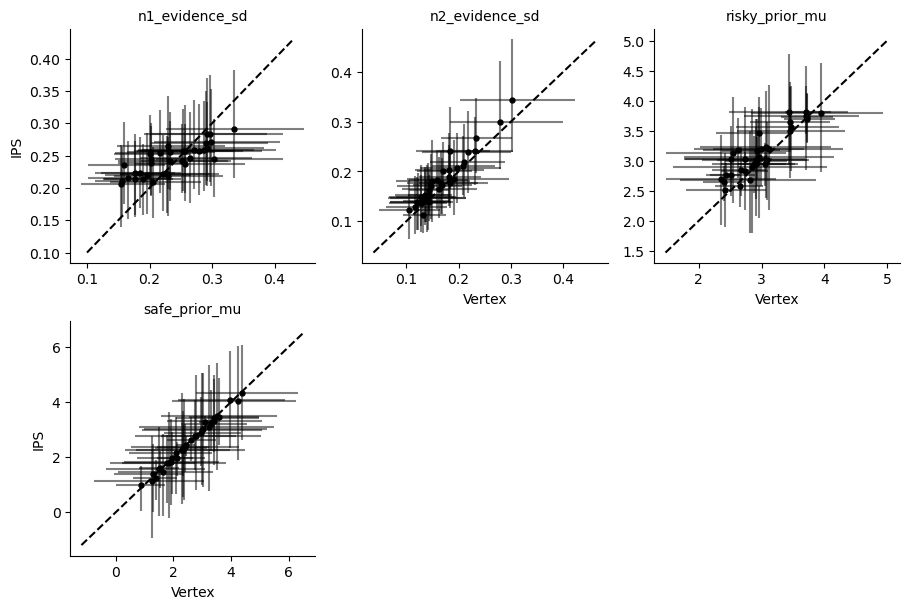

In [13]:
plot_individual_condition_difference(subject_pars)

# plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars_before_after.pdf'))

### PPC

In [15]:
model.ppc?

Signature: model.ppc(paradigm, idata, var_names=['ll_bernoulli'])
Docstring: <no docstring>
File:      ~/git/bauer/bauer/core.py
Type:      method

In [16]:
model.build_estimation_model()
ppc = model.ppc(idata=idata.sel(draw=slice(None, None, 10)), paradigm=df)

ix_risky_first = ppc.index.get_level_values('risky_first')
ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]

Sampling: [ll_bernoulli]


In [18]:
kjppc

chain                                                                                                                                                                                          0  \
draw                                                                                                                                                                                         0     
variable     subject run trial_nr session stimulation_condition rt       n1   n2   p1   p2   choice risky_first chose_risky n_risky n_safe frac     log(risky/safe) log(n1)  bin(risky/safe)       
ll_bernoulli 1       1   1        2       vertex                1.239692 28.0 86.0 1.00 0.55 True   False       True        86.0    28.0   3.071429 1.122143        3.332205 80%               1   
                                  3       ips                   1.008390 20.0 55.0 1.00 0.55 False  False       False       55.0    20.0   2.750000 1.011601        2.995732 68%               1   
                         2        2       vertex                0.836219 7.0  21.0 1.00 0.55 True   False       True        21.0    7.0    3.000000 1.098612        1.945910 80%               1   
                                  3       ips                   1.332120 20.0 39.0 1.00 0.55 False  False       False       39.0    20.0   1.950000 0.667829        2.995732 32%               1   
                         3        2       vertex                0.931371 7.0  21.0 1.00 0.55 True   False       True        21.0    7.0    3.000000 1.098612        1.945910 80%               1   
...                                                                                                                                                                                           ..   
             74      6   118      3       vertex                0.371731 22.0 20.0 0.55 1.00 True   True        False       22.0    20.0   1.100000 0.095310        3.091042 20%               0   
                         119      2       ips                   0.588589 10.0 11.0 1.00 0.55 False  False       False       11.0    10.0   1.100000 0.095310        2.302585 20%               0   
                                  3       vertex                0.705755 14.0 10.0 0.55 1.00 True   True        False       14.0    10.0   1.400000 0.336472        2.639057 32%               0   
                         120      2       ips                   0.722374 7.0  16.0 1.00 0.55 False  False       False       16.0    7.0    2.285714 0.826679        1.945910 56%               0   
                                  3       vertex                0.672241 15.0 14.0 0.55 1.00 True   True        False       15.0    14.0   1.071429 0.068993        2.708050 20%               0   

chain                                                                                                                                                                                             \
draw                                                                                                                                                                                         10    
variable     subject run trial_nr session stimulation_condition rt       n1   n2   p1   p2   choice risky_first chose_risky n_risky n_safe frac     log(risky/safe) log(n1)  bin(risky/safe)       
ll_bernoulli 1       1   1        2       vertex                1.239692 28.0 86.0 1.00 0.55 True   False       True        86.0    28.0   3.071429 1.122143        3.332205 80%               1   
                                  3       ips                   1.008390 20.0 55.0 1.00 0.55 False  False       False       55.0    20.0   2.750000 1.011601        2.995732 68%               1   
                         2        2       vertex                0.836219 7.0  21.0 1.00 0.55 True   False       True        21.0    7.0    3.000000 1.098612        1.945910 80%               1   
                                  3       ips                   1.332120 20.0 3

In [55]:
from tms_risk.cogmodels.utils import cluster_offers, summarize_ppc, plot_prediction

def plot_ppc(df, ppc, plot_type=1, var_name='ll_bernoulli', level='subject', col_wrap=5, legend=True, **kwargs):

    assert (var_name in ['p', 'll_bernoulli'])

    ppc = ppc.xs(var_name, 0, 'variable').copy()

    df = df.copy()

    # Make sure that we group data from (Roughly) same fractions
    if not (df.groupby(['subject', 'log(risky/safe)']).size().groupby('subject').size() < 7).all():
        df['log(risky/safe)'] = df.groupby(['subject'],
                                        group_keys=False).apply(cluster_offers)
        # df = df.set_index('log(risky/safe)', append=True)

    print(df)

    if level == 'group':
        df['log(risky/safe)'] = df['bin(risky/safe)']
        ppc.reset_index('log(risky/safe)', drop=True, inplace=True)
        # ppc.set_index(df['log(risky/safe)'], append=True, inplace=True)
        ppc['log(risky/safe)'] = ppc.index.get_level_values('bin(risky/safe)')
        ppc.set_index('log(risky/safe)', append=True, inplace=True)

    if plot_type == 0:
        groupby = ['log(risky/safe)', 'stimulation_condition']
    elif plot_type == 1:
        groupby = ['risky_first', 'log(risky/safe)']
    elif plot_type in [2, 4]:
        groupby = ['risky_first', 'n_safe']
    elif plot_type in [3, 5]:
        groupby = ['risky_first', 'n_safe', 'log(risky/safe)']
    elif plot_type in [6]:
        groupby = ['risky_first', 'n_safe', 'stimulation_condition']
    elif plot_type in [7]:
        groupby = ['risky_first', 'log(risky/safe)', 'stimulation_condition']
    elif plot_type in [8, 9]:
        groupby = ['risky_first', 'log(risky/safe)', 'stimulation_condition', 'n_safe']
    else:
        raise NotImplementedError

    if level == 'group':
        print(ppc.columns)
        ppc = ppc.groupby(['subject']+groupby).mean()
        print(ppc.iloc[:, :2])

    if level == 'subject':
        groupby = ['subject'] + groupby

    ppc_summary = summarize_ppc(ppc, groupby=groupby)
    p = df.groupby(groupby)[['chose_risky']].mean()
    ppc_summary = ppc_summary.join(p).reset_index()

    if 'risky_first' in ppc_summary.columns:
        ppc_summary['Order'] = ppc_summary['risky_first'].map({True:'Risky first', False:'Safe first'})

    if 'n_safe' in groupby:
        ppc_summary['Safe offer'] = ppc_summary['n_safe'].astype(int)

    ppc_summary['Prop. chosen risky'] = ppc_summary['chose_risky']

    if 'log(risky/safe)' in groupby:
        if level == 'group':
            ppc_summary['Predicted acceptance'] = ppc_summary['log(risky/safe)']
        else:
            ppc_summary['Log-ratio offer'] = ppc_summary['log(risky/safe)']

    if plot_type in [2, 6]:
        x = 'Safe offer'
    else:
        if level == 'group':
            x = 'Predicted acceptance'
        else:
            x = 'Log-ratio offer'


    if plot_type in [0]:
        fac = sns.FacetGrid(ppc_summary,
                            col='subject' if level == 'subject' else None,
                            hue='stimulation_condition',
                            col_wrap=col_wrap if level == 'subject' else None,
                            hue_order=['vertex', 'ips'],
                            palette=sns.color_palette()[2:],
                            **kwargs)


    elif plot_type in [1, 2]:
        fac = sns.FacetGrid(ppc_summary,
                            col='subject' if level == 'subject' else None,
                            hue='Order',
                            col_wrap=col_wrap if level == 'subject' else None,
                            **kwargs)

    elif plot_type == 3:
        fac = sns.FacetGrid(ppc_summary,
                            col='Safe offer',
                            hue='Order',
                            row='subject' if level == 'subject' else None,
                            **kwargs)
    elif plot_type == 4:


        if level == 'group':
            rnp = df.groupby(['subject'] + groupby, group_keys=False).apply(get_rnp).to_frame('rnp')
            rnp = rnp.groupby(groupby).mean()
        else:
            rnp = df.groupby(groupby, group_keys=False).apply(get_rnp).to_frame('rnp')

        ppc_summary = ppc_summary.join(rnp)
        fac = sns.FacetGrid(ppc_summary,
                            hue='Order',
                            col='subject' if level == 'subject' else None,
                            col_wrap=col_wrap if level == 'subject' else None,
                            **kwargs)

        fac.map_dataframe(plot_prediction, x='Safe offer', y='p_predicted')
        fac.map(plt.scatter, 'Safe offer', 'rnp')
        fac.map(lambda *args, **kwargs: plt.axhline(.55, c='k', ls='--'))

    elif plot_type == 5:
        fac = sns.FacetGrid(ppc_summary,
                            col='Order',
                            hue='Safe offer',
                            row='subject' if level == 'subject' else None,
                            palette='coolwarm',
                            **kwargs)

    elif plot_type == 6:
        fac = sns.FacetGrid(ppc_summary,
                            col='Order',
                            hue='stimulation_condition',
                            hue_order=['vertex', 'ips'],
                            row='subject' if level == 'subject' else None,
                            palette=sns.color_palette()[2:],
                            **kwargs)

    elif plot_type == 7:
        fac = sns.FacetGrid(ppc_summary,
                            col='Order',
                            hue='stimulation_condition',
                            hue_order=['vertex', 'ips'],
                            row='subject' if level == 'subject' else None,
                            palette=sns.color_palette()[2:],
                            **kwargs)

    elif plot_type == 8:
        if level == 'subject':
            raise NotImplementedError

        fac = sns.FacetGrid(ppc_summary,
                            col='Order',
                            hue='Safe offer',
                            row='stimulation_condition',
                            hue_order=['vertex', 'ips'],
                            palette='coolwarm',
                            **kwargs)

    elif plot_type == 9:
        if level == 'subject':
            raise NotImplementedError

        fac = sns.FacetGrid(ppc_summary,
                            col='Order',
                            hue='stimulation_condition',
                            hue_order=['vertex', 'ips'],
                            row='Safe offer',
                            palette=sns.color_palette()[2:],
                            **kwargs)


    if plot_type in [0, 1,2,3, 5, 6, 7, 8, 9]:
        fac.map_dataframe(plot_prediction, x=x)
        fac.map(plt.scatter, x, 'Prop. chosen risky')
        fac.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))

    if plot_type in [0, 1, 3, 5, 7, 9]:
        if level == 'subject':
            fac.map(lambda *args, **kwargs: plt.axvline(np.log(1./.55), c='k', ls='--'))
        else:
            fac.map(lambda *args, **kwargs: plt.axvline(2.5, c='k', ls='--'))

    
    if legend:
        fac.add_legend()

    return fac

                      session stimulation_condition        rt    n1    n2  \
subject run trial_nr                                                        
1       1   1               2                vertex  1.239692  28.0  86.0   
            2               2                vertex  0.836219   7.0  21.0   
            3               2                vertex  0.931371   7.0  21.0   
            4               2                vertex  1.135164  10.0  24.0   
            5               2                vertex  1.032161  20.0  44.0   
...                       ...                   ...       ...   ...   ...   
74      6   116             3                vertex  1.055890  37.0  20.0   
            117             3                vertex  0.739095  55.0  14.0   
            118             3                vertex  0.371731  22.0  20.0   
            119             3                vertex  0.705755  14.0  10.0   
            120             3                vertex  0.672241  15.0  14.0   

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


                      session stimulation_condition        rt    n1    n2  \
subject run trial_nr                                                        
1       1   1               2                vertex  1.239692  28.0  86.0   
            2               2                vertex  0.836219   7.0  21.0   
            3               2                vertex  0.931371   7.0  21.0   
            4               2                vertex  1.135164  10.0  24.0   
            5               2                vertex  1.032161  20.0  44.0   
...                       ...                   ...       ...   ...   ...   
74      6   116             3                vertex  1.055890  37.0  20.0   
            117             3                vertex  0.739095  55.0  14.0   
            118             3                vertex  0.371731  22.0  20.0   
            119             3                vertex  0.705755  14.0  10.0   
            120             3                vertex  0.672241  15.0  14.0   

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


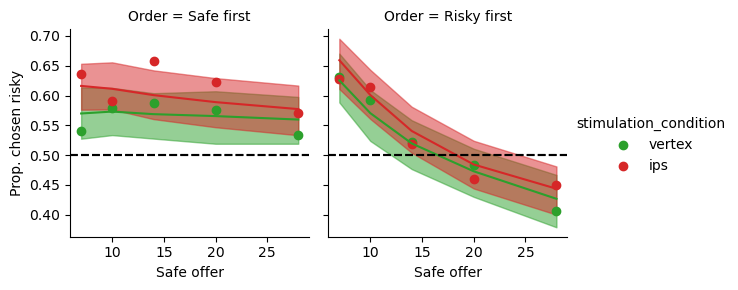

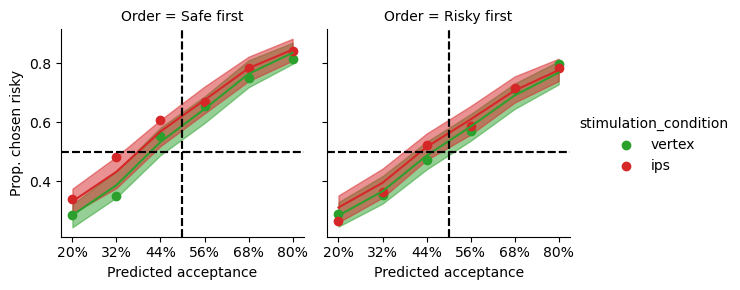

In [56]:
for plot_type in [5,6,7][1:3]:
    plot_ppc(df, ppc, plot_type=plot_type, level='group')
    # plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-1_ppc{plot_type}.pdf'))

# Model 1c

In [57]:
model_label = '1c'
df, model, idata = get_info(model_label)
pars = get_pars(idata)

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:279: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', 

Dropping the baseline condition
n1_evidence_sd_mu
n2_evidence_sd_mu
risky_prior_mu_mu
safe_prior_mu_mu


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette

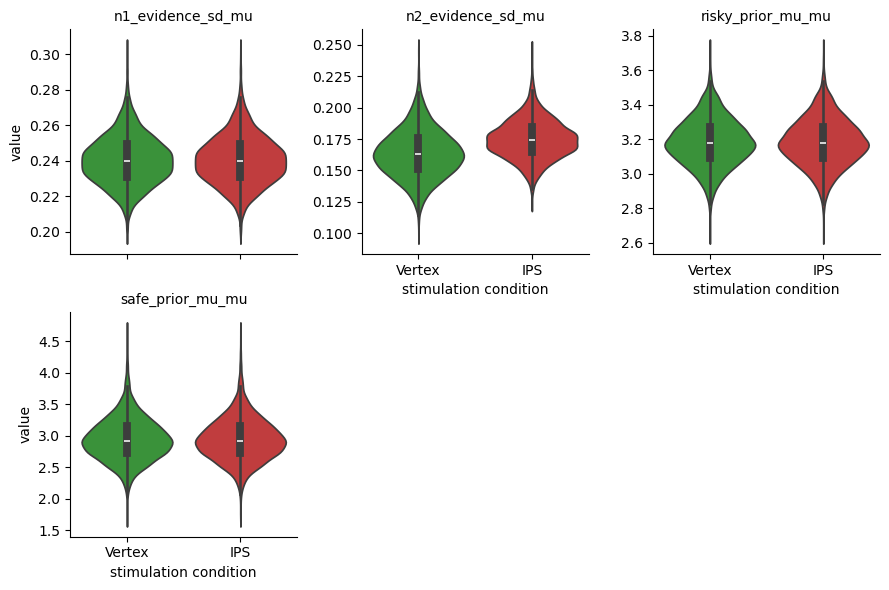

In [58]:
g = plot_pars(pars, df)
# g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars.pdf'))

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)


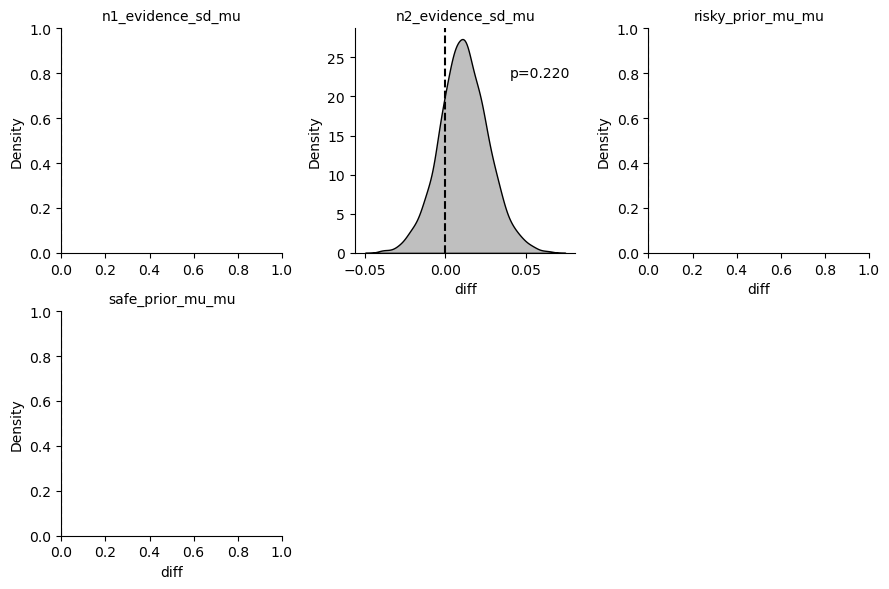

In [59]:
g = plot_pars_diff(pars)
# g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars_diff.pdf'))

n1_evidence_sd
n2_evidence_sd
risky_prior_mu
safe_prior_mu


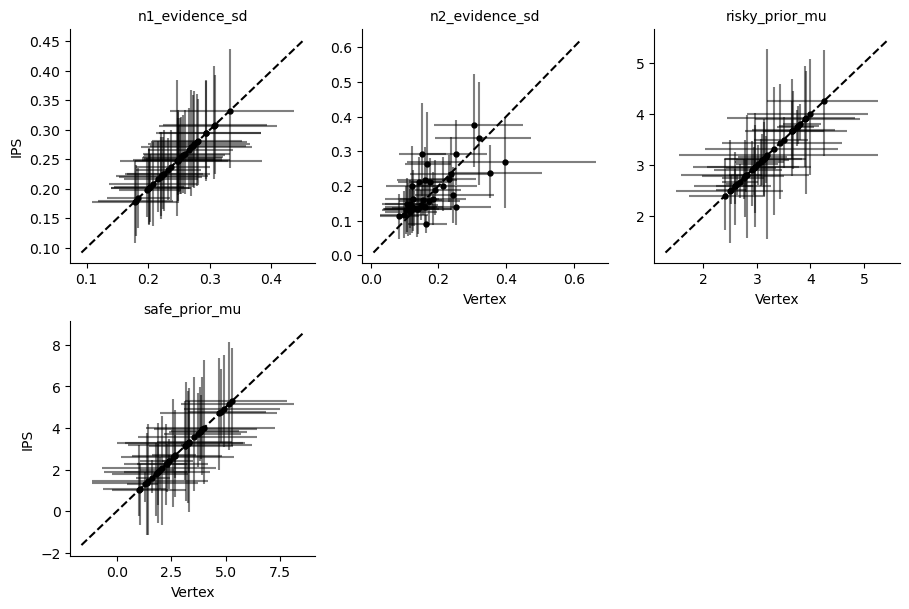

In [60]:
subject_pars = get_pars(idata, group=False)
plot_individual_condition_difference(subject_pars)
# plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars_before_after.pdf'))

## PPC

In [66]:
model.build_estimation_model()
ppc = model.ppc(idata=idata.sel(draw=slice(None, None, 10)), paradigm=df)

ix_risky_first = ppc.index.get_level_values('risky_first')
ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]

Sampling: [ll_bernoulli]


                      session stimulation_condition        rt    n1    n2  \
subject run trial_nr                                                        
1       1   1               2                vertex  1.239692  28.0  86.0   
            2               2                vertex  0.836219   7.0  21.0   
            3               2                vertex  0.931371   7.0  21.0   
            4               2                vertex  1.135164  10.0  24.0   
            5               2                vertex  1.032161  20.0  44.0   
...                       ...                   ...       ...   ...   ...   
74      6   116             3                vertex  1.055890  37.0  20.0   
            117             3                vertex  0.739095  55.0  14.0   
            118             3                vertex  0.371731  22.0  20.0   
            119             3                vertex  0.705755  14.0  10.0   
            120             3                vertex  0.672241  15.0  14.0   

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


                      session stimulation_condition        rt    n1    n2  \
subject run trial_nr                                                        
1       1   1               2                vertex  1.239692  28.0  86.0   
            2               2                vertex  0.836219   7.0  21.0   
            3               2                vertex  0.931371   7.0  21.0   
            4               2                vertex  1.135164  10.0  24.0   
            5               2                vertex  1.032161  20.0  44.0   
...                       ...                   ...       ...   ...   ...   
74      6   116             3                vertex  1.055890  37.0  20.0   
            117             3                vertex  0.739095  55.0  14.0   
            118             3                vertex  0.371731  22.0  20.0   
            119             3                vertex  0.705755  14.0  10.0   
            120             3                vertex  0.672241  15.0  14.0   

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


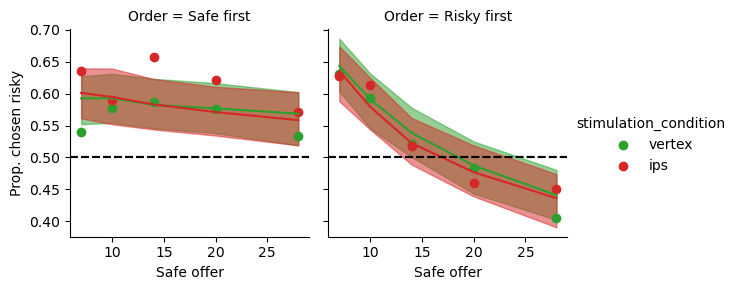

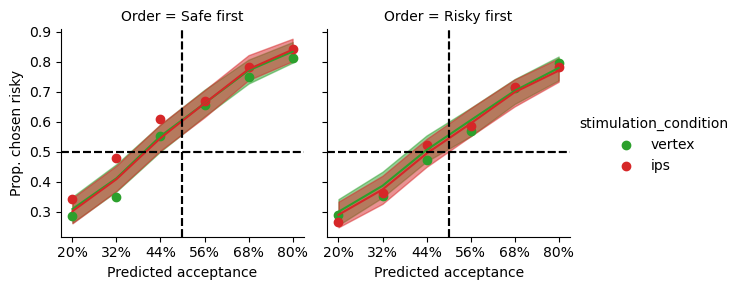

In [67]:
for plot_type in [5,6,7][1:3]:
    plot_ppc(df, ppc, plot_type=plot_type, level='group')
    # plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-1_ppc{plot_type}.pdf'))

# Model 6a

In [4]:
process_model('6a')

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition
yo
***Warning, estimating evidence_sd for both first and second option, but (some) regressors affect both equally (via `evidence_sd`)***


KeyError: 'stimulation_condition[T.ips]'

# Model 6b

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition
yo
***Warning, estimating evidence_sd for both first and second option, but (some) regressors affect both equally (via `evidence_sd`)***
n1_evidence_sd_mu
yo
n2_evidence_sd_mu
yo
risky_prior_mu_mu
risky_prior_std_mu
safe_prior_mu_mu
safe_prior_std_mu


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserW

n1_evidence_sd
yo
n2_evidence_sd
yo
risky_prior_mu
risky_prior_std
safe_prior_mu
safe_prior_std
***Warning, estimating evidence_sd for both first and second option, but (some) regressors affect both equally (via `evidence_sd`)***


Sampling: [ll_bernoulli]


/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future rel

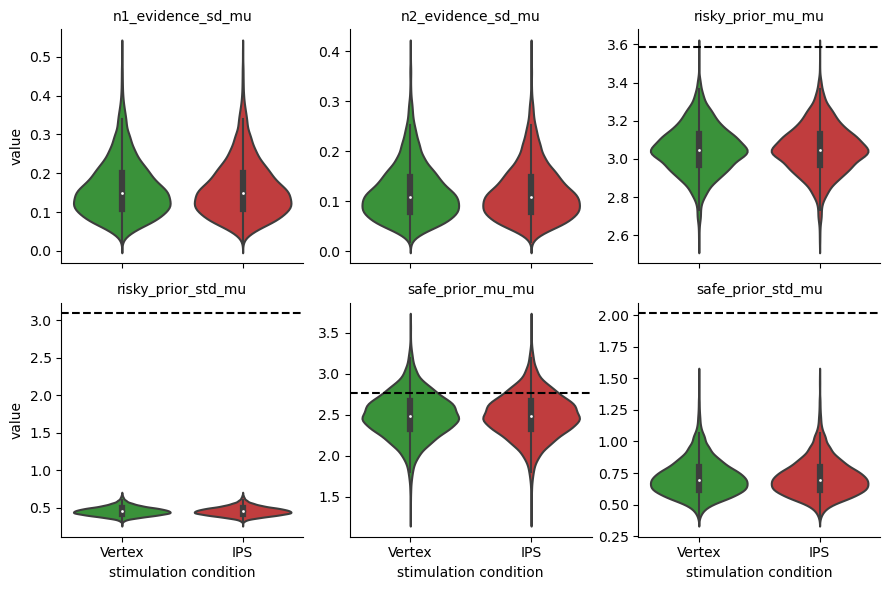

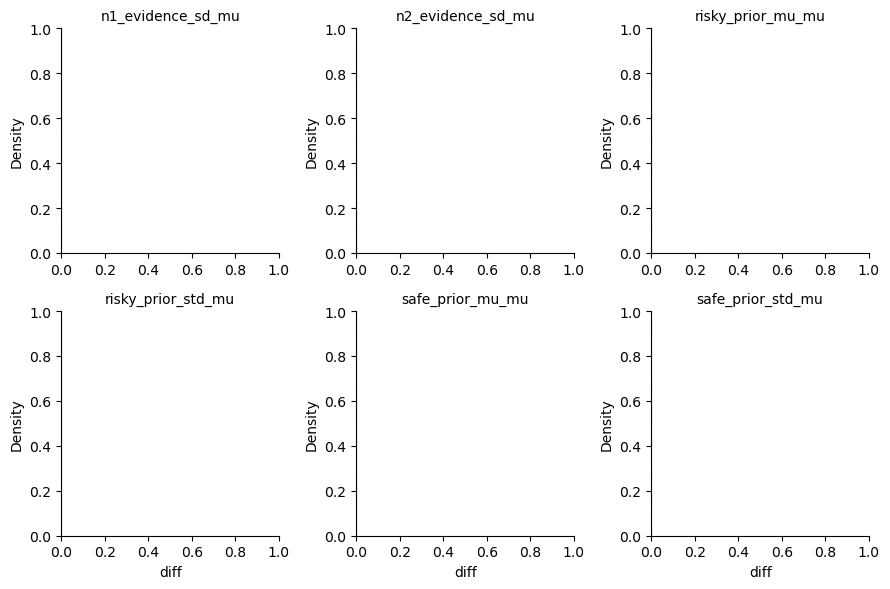

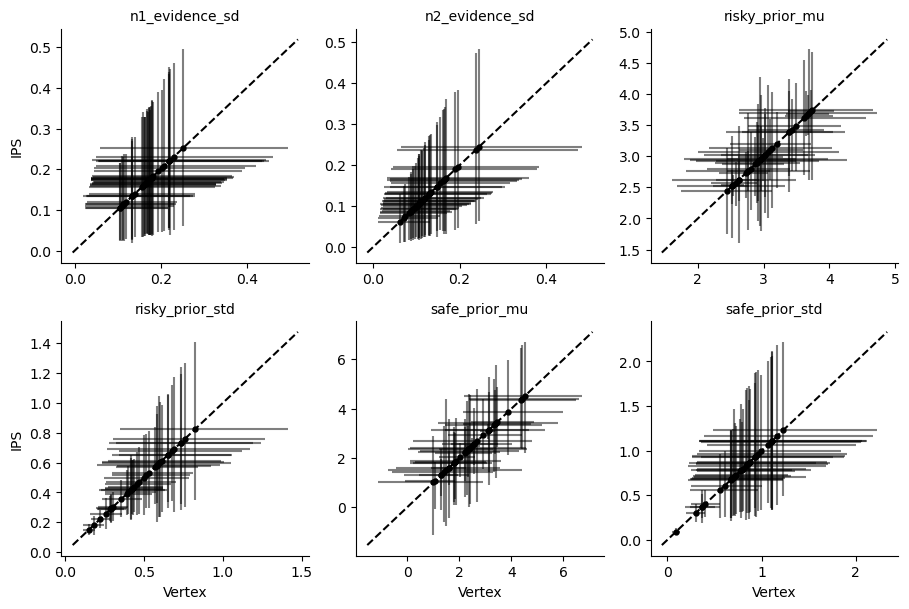

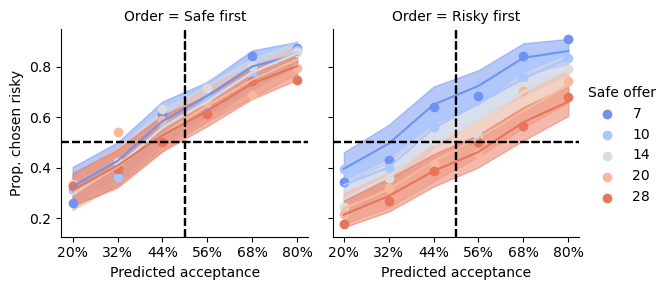

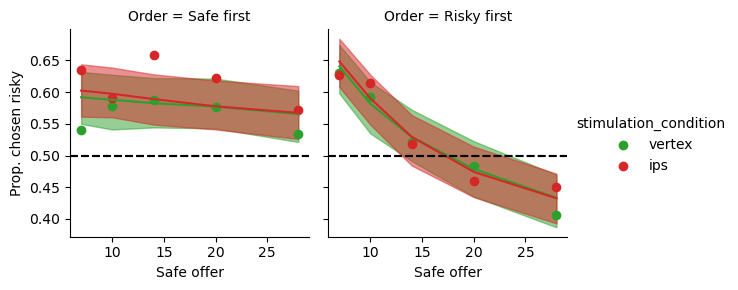

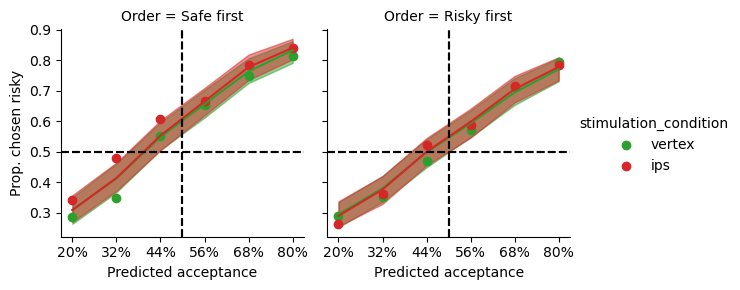

In [7]:
process_model('6b')

# Model 5

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


Sampling: [ll_bernoulli]


/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future rel

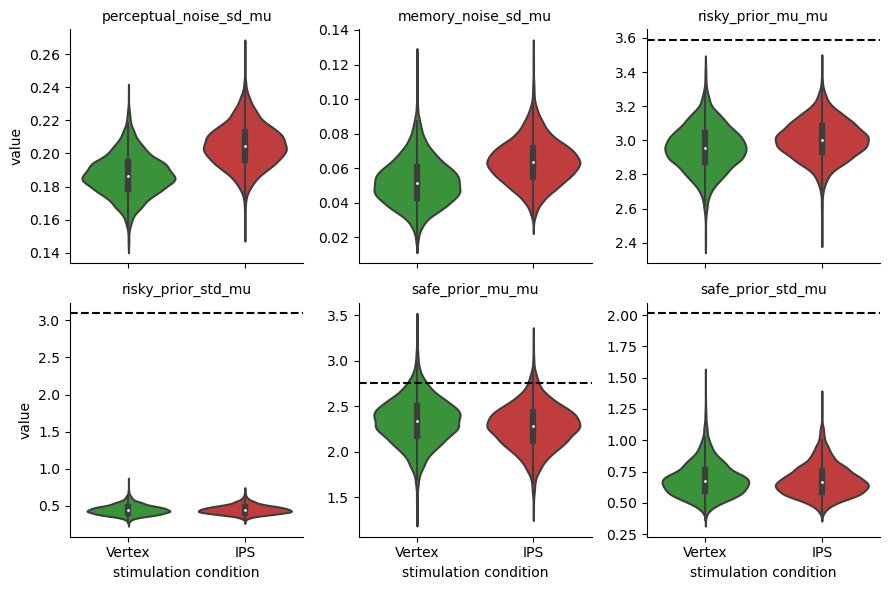

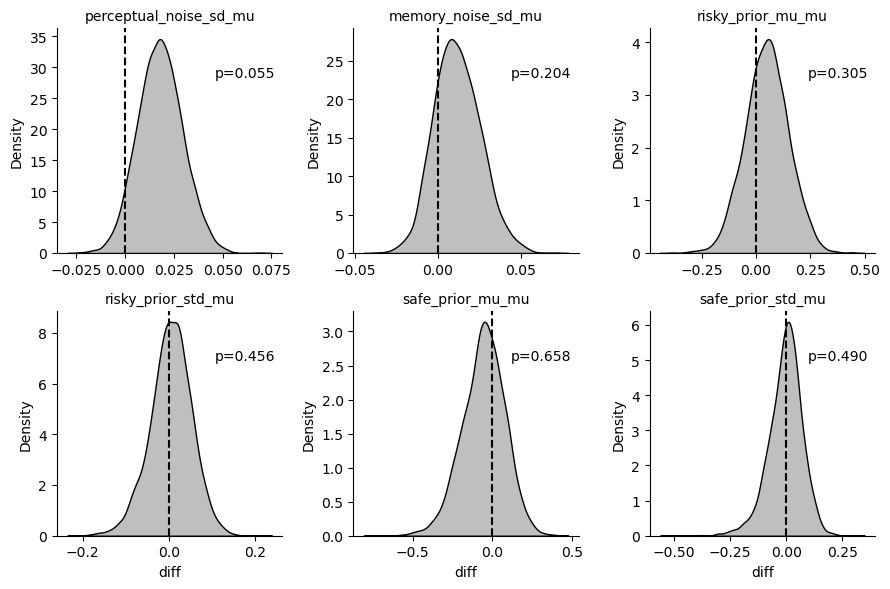

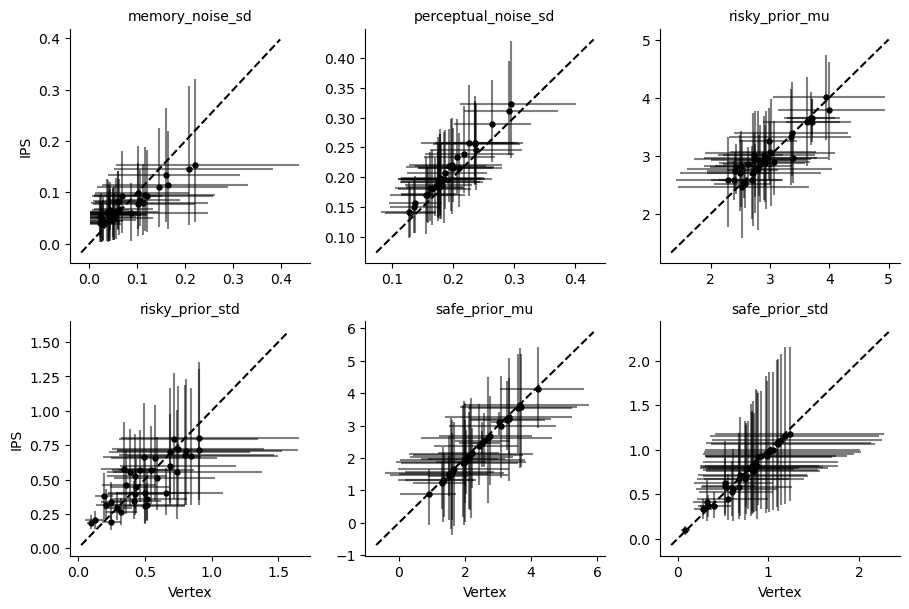

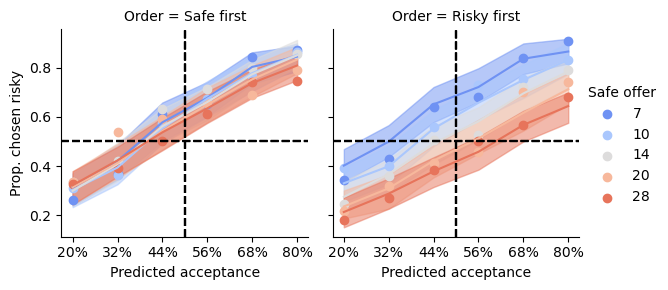

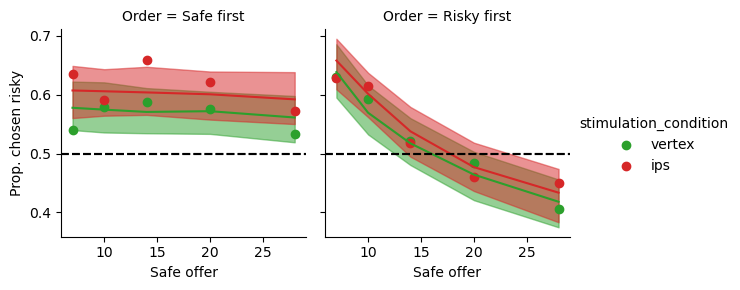

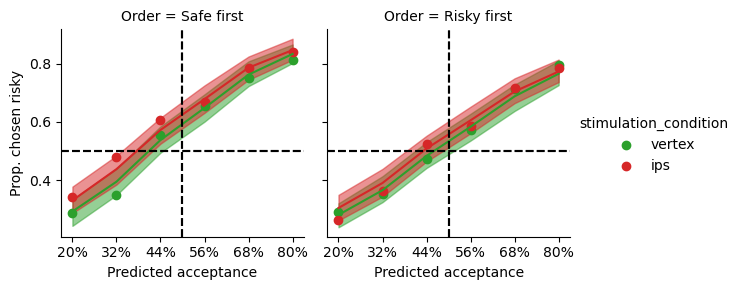

In [10]:
process_model('5')

# Model 5b

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
Sampling: [ll_bernoulli]


/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future rel

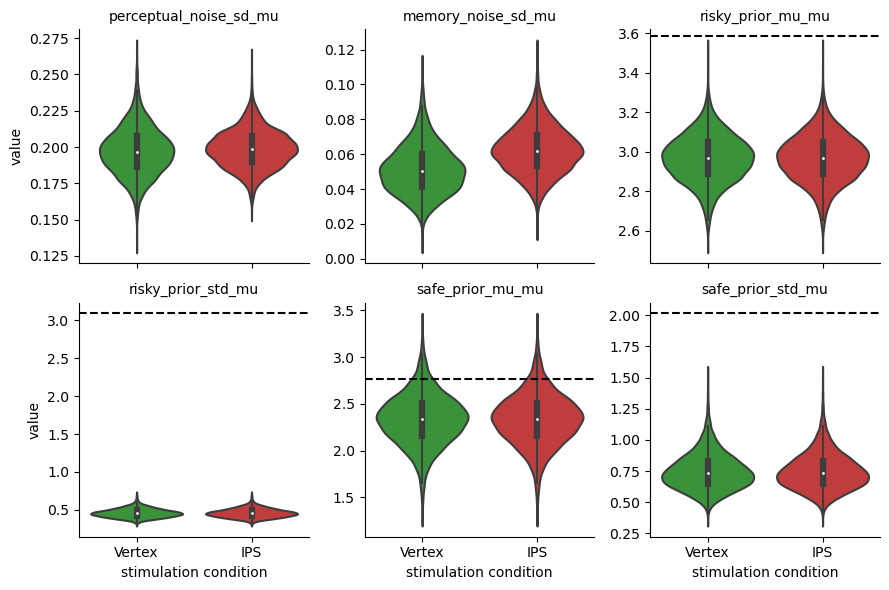

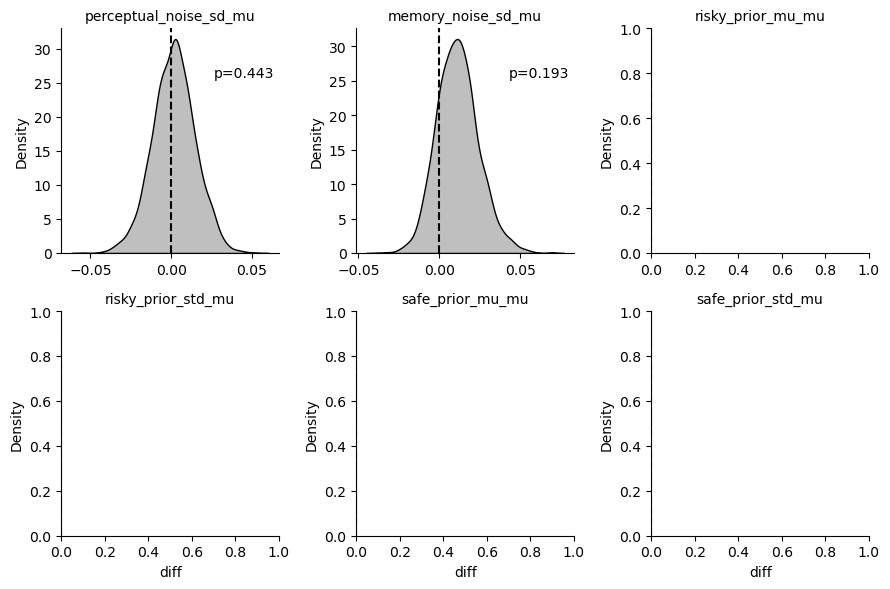

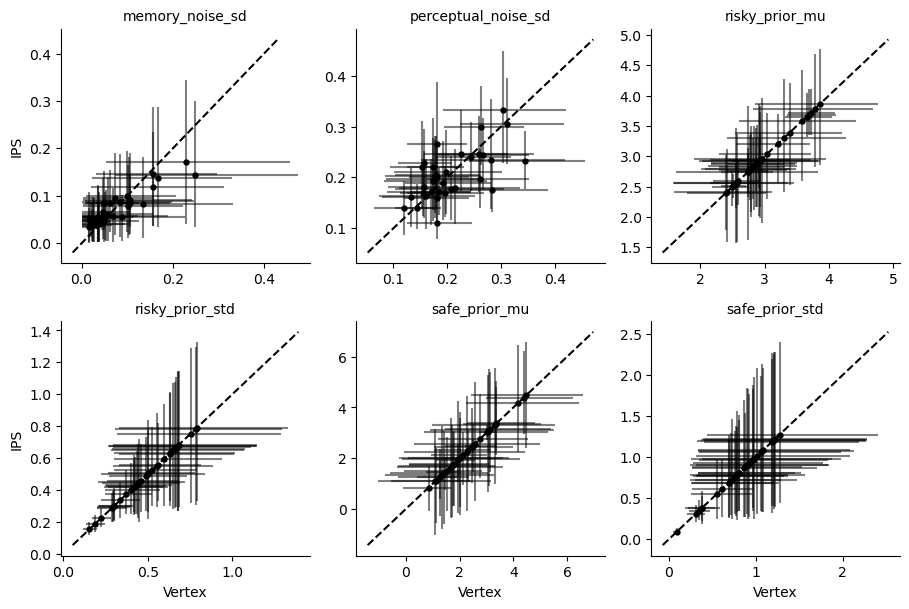

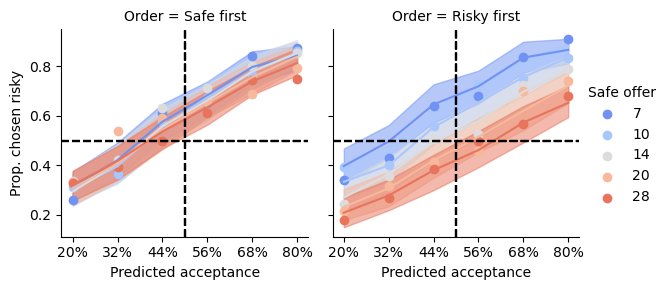

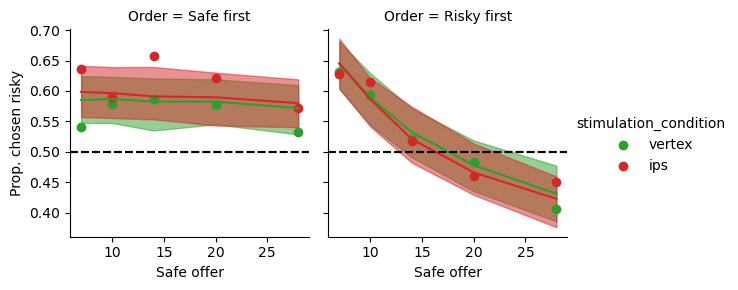

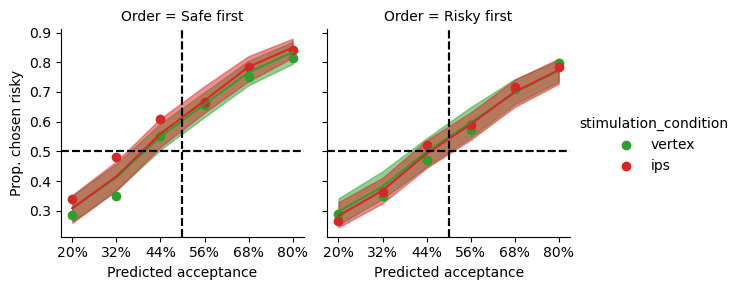

In [11]:
process_model('5b')

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition
perceptual_noise_sd_mu
memory_noise_sd_mu
prior_mu_mu
prior_std_mu


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)


perceptual_noise_sd
memory_noise_sd
prior_mu
prior_std


Sampling: [ll_bernoulli]


/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future rel

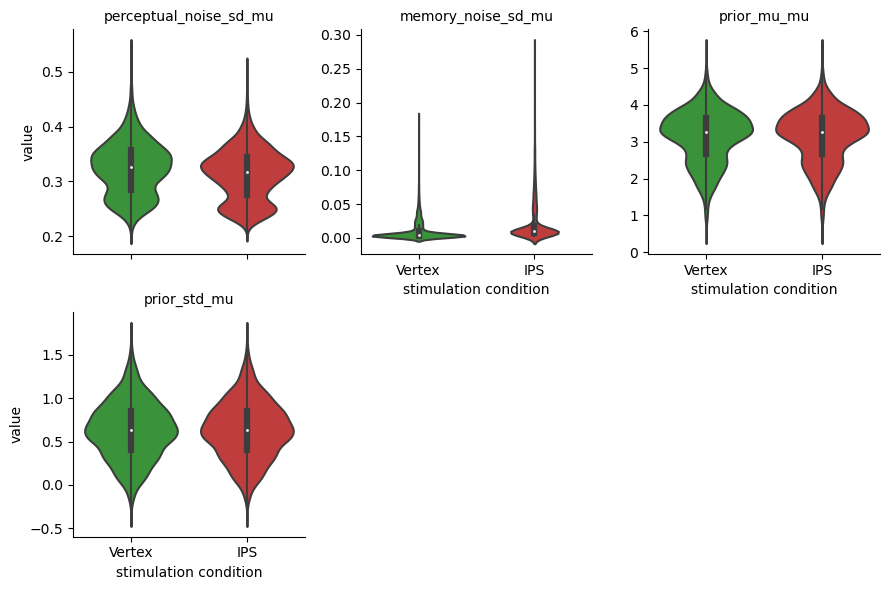

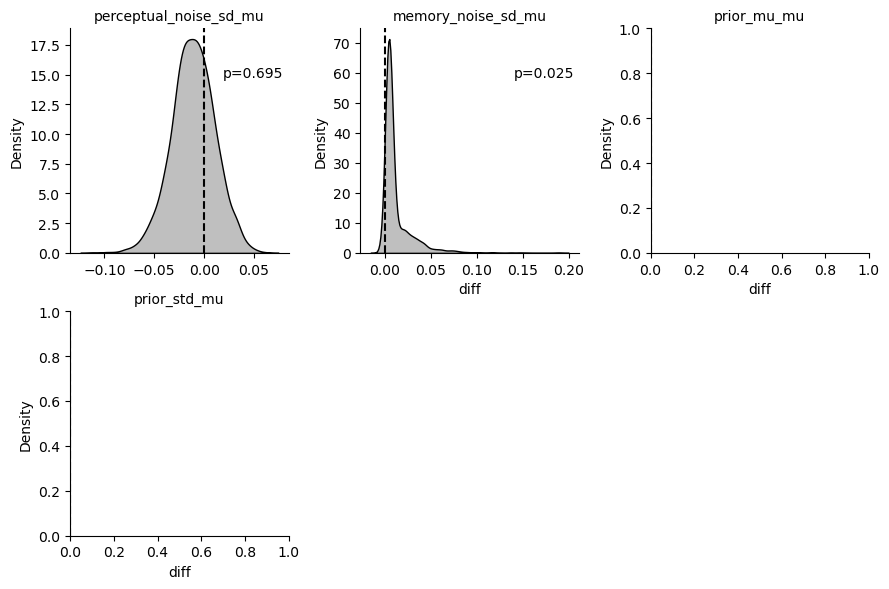

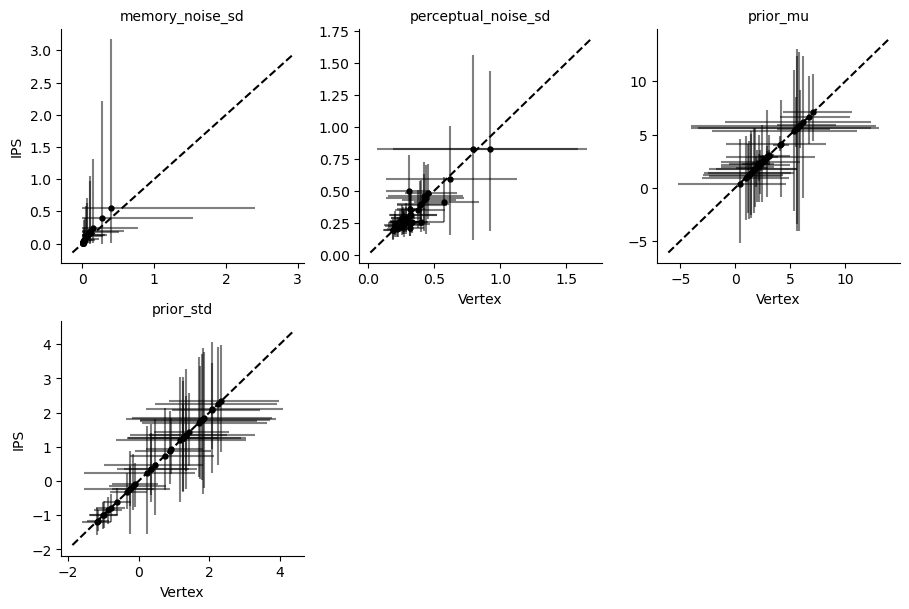

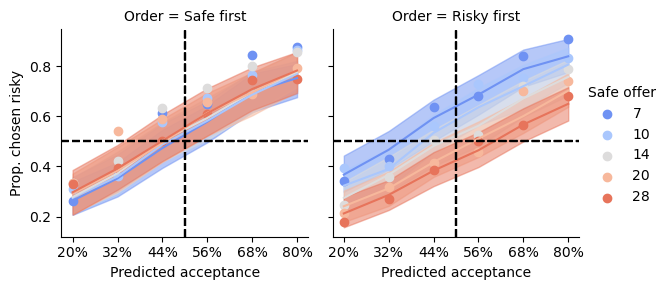

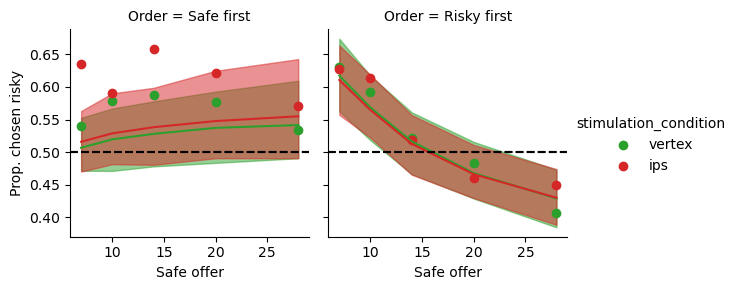

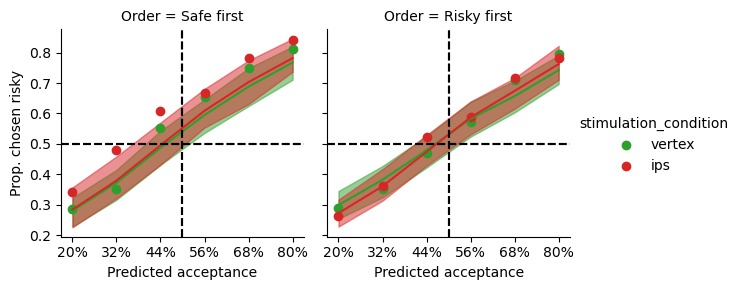

In [7]:
process_model('5c')